In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False


data = pd.read_csv('dataset/in_and_out.csv', encoding='cp949')
data.head()

,사용월,호선명,지하철역,04시-05시 승차인원,04시-05시 하차인원,05시-06시 승차인원,05시-06시 하차인원,06시-07시 승차인원,06시-07시 하차인원,07시-08시 승차인원,...,23시-24시 하차인원,00시-01시 승차인원,00시-01시 하차인원,01시-02시 승차인원,01시-02시 하차인원,02시-03시 승차인원,02시-03시 하차인원,03시-04시 승차인원,03시-04시 하차인원,작업일자
0,202504,1호선,동대문,650,26,11355,2005,10238,7181,18411,...,9939,938,3210,3,321,0,0,0,0,20250503
1,202504,1호선,동묘앞,117,3,2844,819,4206,5444,9689,...,4897,120,1996,3,267,0,0,0,0,20250503
2,202504,1호선,서울역,712,48,10654,9668,29272,64058,97455,...,29252,5212,8018,10,262,0,0,0,0,20250503
3,202504,1호선,시청,124,5,2267,5900,3888,28761,7841,...,3763,606,1015,0,15,0,0,0,0,20250503
4,202504,1호선,신설동,381,18,9393,2330,10420,9020,24157,...,9416,455,3039,0,0,1,2,0,0,20250503


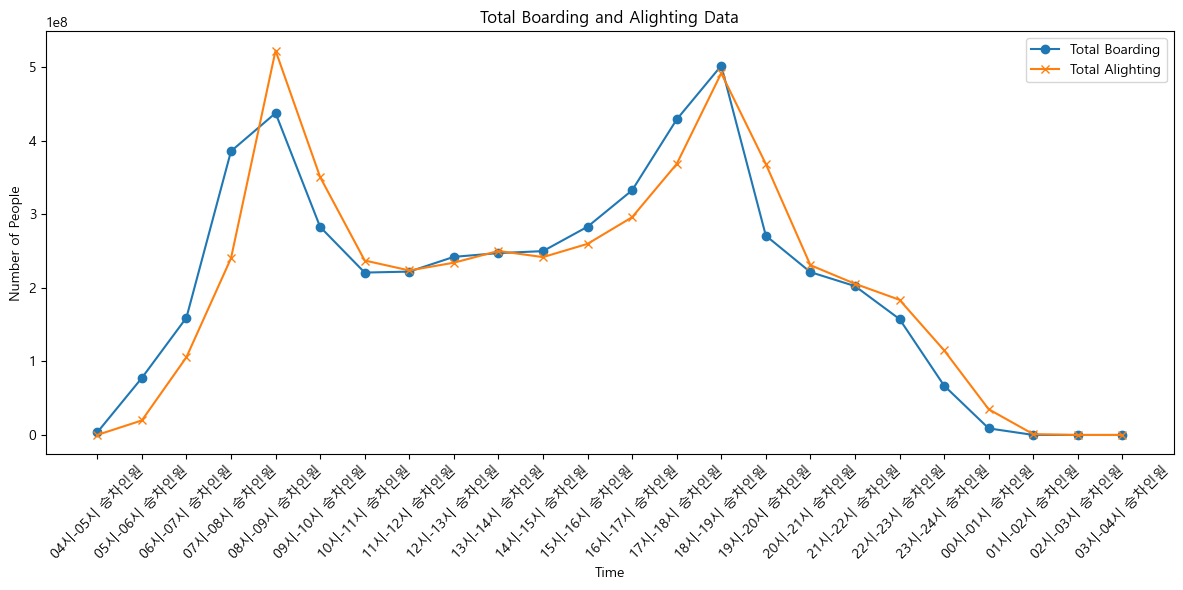

In [48]:
# '승차인원'이 포함된 컬럼명을 모두 추출하여 리스트로 저장
boarding_cols = [col for col in data.columns if '승차인원' in col]

# '하차인원'이 포함된 컬럼명을 모두 추출하여 리스트로 저장
alighting_cols = [col for col in data.columns if '하차인원' in col]

# 각 행(관측치)별로 모든 시간대의 승차인원 합계를 계산 (axis=1은 행 단위 연산)
boarding_data = data[boarding_cols].sum(axis=1)

# 각 행(관측치)별로 모든 시간대의 하차인원 합계를 계산
alighting_data = data[alighting_cols].sum(axis=1)

plt.figure(figsize=(12, 6))  # 전체 그래프 크기 설정

# 전체 데이터에서 시간대별 승차인원 합계를 선 그래프로 시각화 (마커: 원형)
plt.plot(
    boarding_cols,                      # x축: 시간대별 승차인원 컬럼명
    data[boarding_cols].sum(),          # y축: 각 시간대별 승차인원 총합
    label='Total Boarding', marker='o'
)

# 전체 데이터에서 시간대별 하차인원 합계를 선 그래프로 시각화 (마커: x)
plt.plot(
    boarding_cols,                      # x축을 boarding_cols로 통일하여 시간대 정렬을 일치시킴
    data[alighting_cols].sum(),         # y축: 각 시간대별 하차인원 총합
    label='Total Alighting', marker='x'
)

plt.title('Total Boarding and Alighting Data')  # 그래프 제목
plt.xlabel('Time')                             # x축 레이블
plt.ylabel('Number of People')                 # y축 레이블
plt.xticks(rotation=45)                        # x축 라벨 45도 회전 (가독성 향상)
plt.legend()                                   # 범례 표시
plt.tight_layout()                             # 레이아웃 자동 조정
plt.show()                                     # 그래프 출력


# 전처리

In [33]:
from sklearn.preprocessing import MinMaxScaler  # 데이터 정규화를 위한 MinMaxScaler 임포트

# '승차' 또는 '하차'가 포함된 컬럼명을 모두 추출 (시간대별 승하차 컬럼 리스트)
time_cols = [col for col in data.columns if '승차' in col or '하차' in col]

# 시간대 문자열에서 시와 분을 분 단위로 변환하여 정렬 기준으로 사용하기 위한 함수
def time_sort_key(x):
    h, m = map(int, x.split('-')[0].split('시'))  # 예: '06시-30분' → 6, 30
    return h * 60 + m if m else h * 60           # 분 단위 환산 (06시-30분 → 390)

# 시간대만 추출해서 중복 제거 후, 분 단위로 정렬
# 예: ['06시-00분', '06시-30분', ...]
time_order = sorted(
    set(col.split()[0] for col in time_cols), 
    key=lambda x: int(x[:2])*60+int(x[3:5])
)

# 정렬된 시간대별로 승차인원, 하차인원 컬럼명을 순서대로 리스트에 추가
ordered_cols = []
for t in time_order:
    ordered_cols.append(f'{t} 승차인원')   # 예: '06시-30분 승차인원'
    ordered_cols.append(f'{t} 하차인원')   # 예: '06시-30분 하차인원'

# 메타데이터('사용월', '호선명', '지하철역')와 정렬된 시간대별 승차/하차 컬럼만 남겨 데이터프레임 재정렬
data = data[['사용월', '호선명', '지하철역'] + ordered_cols]

# 월 기준으로 훈련/테스트 데이터 분할 (2025년 1월 이전: train, 이후: test)
train = data[data['사용월'] < 202501]
test = data[data['사용월'] >= 202501]

# 시계열 입력(X)/타겟(y) 생성 함수 정의
def make_xy(df, window_size=3):
    X, y = [], []
    # 각 역별로 그룹화하여 슬라이딩 윈도우 적용
    for _, group in df.groupby(['호선명', '지하철역']):
        vals = group[ordered_cols].values  # 시간대별 승하차 데이터만 numpy 배열로 추출
        # 한 역에 여러 달 데이터가 있을 수 있으니 각 행별로 반복
        for row in vals:
            # 시간대별로 슬라이딩 윈도우 적용
            for i in range(0, len(ordered_cols)//2 - window_size):
                start = i*2                        # 윈도우 시작 인덱스 (2는 승차/하차)
                end = (i+window_size)*2            # 윈도우 끝 인덱스
                X.append(row[start:end])           # 입력: 연속된 window_size개 시간대의 승차/하차
                y.append(row[end:end+2])           # 타깃: 바로 다음 시간대의 승차/하차 (2개)
    return np.array(X), np.array(y)

# 입력/타겟 데이터 생성 (윈도우 크기=3)
window_size = 3
X_train, y_train = make_xy(train, window_size)
X_test, y_test = make_xy(test, window_size)

# 입력(X), 타깃(y) 각각에 대해 0~1 범위로 정규화 (MinMaxScaler)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)  # 훈련 입력 데이터로 스케일러 학습 및 변환
X_test = scaler_X.transform(X_test)        # 테스트 입력 데이터 변환 (훈련 기준)
y_train = scaler_y.fit_transform(y_train)  # 훈련 타깃 데이터로 스케일러 학습 및 변환
y_test = scaler_y.transform(y_test)        # 테스트 타깃 데이터 변환 (훈련 기준)

# 입력 데이터 형태를 (샘플수, 윈도우 크기, 2)로 변경 (LSTM 등 시계열 딥러닝 모델 입력용)
X_train = X_train.reshape(-1, window_size, 2)
X_test = X_test.reshape(-1, window_size, 2)




# LSTM

Epoch 1/30


c:\Users\kkh01\llll\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6499/6499 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 9.3698e-04 - val_loss: 1.4332e-04
Epoch 2/30
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 5.6780e-04 - val_loss: 1.1638e-04
Epoch 3/30
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 4.4998e-04 - val_loss: 1.0509e-04
Epoch 4/30
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 4.0852e-04 - val_loss: 1.1268e-04
Epoch 5/30
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 3.7446e-04 - val_loss: 1.1515e-04
Epoch 6/30
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 3.6487e-04 - val_loss: 1.0224e-04
Epoch 7/30
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 3.4334e-04 - val_loss: 9.7068e-05
Epoch 8/30
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 3.3092e-04 - val_loss: 1.0405e-04
Epoch 9/30
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 3.2740e-04 - val_loss: 9.4650e-05
Epoch 10/30
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 3.0962e-04 - val_loss: 1.0570e-04
Epoch 11/30
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,896 (226.16 KB)

 Trainable params: 19,298 (75.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,598 (150.78 KB)

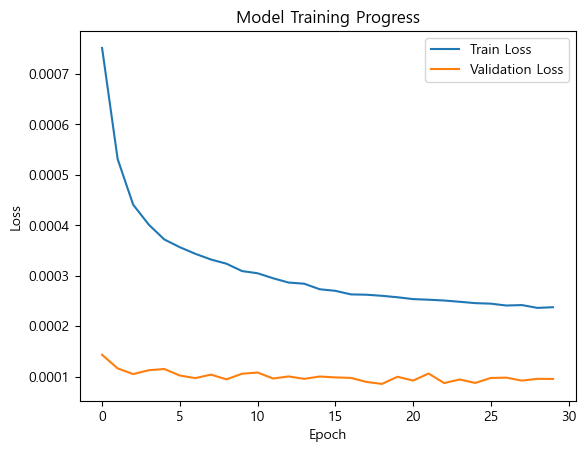

In [49]:
from tensorflow.keras.models import Sequential  # 신경망 모델 구성용
from tensorflow.keras.layers import LSTM, Dense  # LSTM 레이어와 전결합층

# LSTM 모델 설계
model = Sequential([
    # 첫 번째 LSTM 레이어: 64개 유닛, 입력 형태 (3시간 단위, 승차/하차 2개 특성)
    # return_sequences=False → 마지막 시점의 출력만 사용
    LSTM(64, input_shape=(3, 2), return_sequences=False),  
    
    # 은닉층: 32개 뉴런, ReLU 활성화 함수 (비선형성 추가)
    Dense(32, activation='relu'),
    
    # 출력층: 2개 뉴런 (승차/하차 인원 예측)
    Dense(2)  
])

# 모델 컴파일 설정
model.compile(
    optimizer='adam',   # Adam 최적화 알고리즘 (학습률 0.001 기본값)
    loss='mse'          # 손실 함수: 평균제곱오차(Mean Squared Error)
)

# 모델 학습 실행
history_lstm = model.fit(
    X_train, y_train,          # 훈련 데이터
    epochs=30,                 # 전체 데이터 30회 반복 학습
    batch_size=32,             # 32개 샘플 단위로 가중치 갱신
    validation_split=0.2,      # 훈련 데이터 20%를 검증용으로 사용
    verbose=1                  # 학습 과정 진행률 표시
)

# 학습 과정 시각화
import matplotlib.pyplot as plt
plt.plot(history_lstm.history['loss'], label='Train Loss')      # 훈련 손실
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')  # 검증 손실
plt.title('Model Training Progress')  # 그래프 제목
plt.ylabel('Loss')       # y축 레이블
plt.xlabel('Epoch')      # x축 레이블
plt.legend()             # 범례 표시
plt.show()               # 그래프 출력



# CNN

Epoch 1/30


c:\Users\kkh01\llll\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8124/8124 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 6.7968e-04 - val_loss: 3.4810e-04
Epoch 2/30
8124/8124 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 3.5497e-04 - val_loss: 3.6499e-04
Epoch 3/30
8124/8124 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 3.1069e-04 - val_loss: 2.7997e-04
Epoch 4/30
8124/8124 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.8420e-04 - val_loss: 2.8422e-04
Epoch 5/30
8124/8124 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.6589e-04 - val_loss: 2.4761e-04
Epoch 6/30
8124/8124 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.5417e-04 - val_loss: 2.3942e-04
Epoch 7/30
8124/8124 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.4132e-04 - val_loss: 2.1473e-04
Epoch 8/30
8124/8124 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.2996e-04 - val_loss: 2.4318e-04
Epoch 9/30
8124/8124 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.2001e-04 - val_loss: 2.1167e-04
Epoch 10/30
8124/8124 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.1481e-04 - val_loss: 2.1262e-04
Epoch 11/30
8124/8124 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms

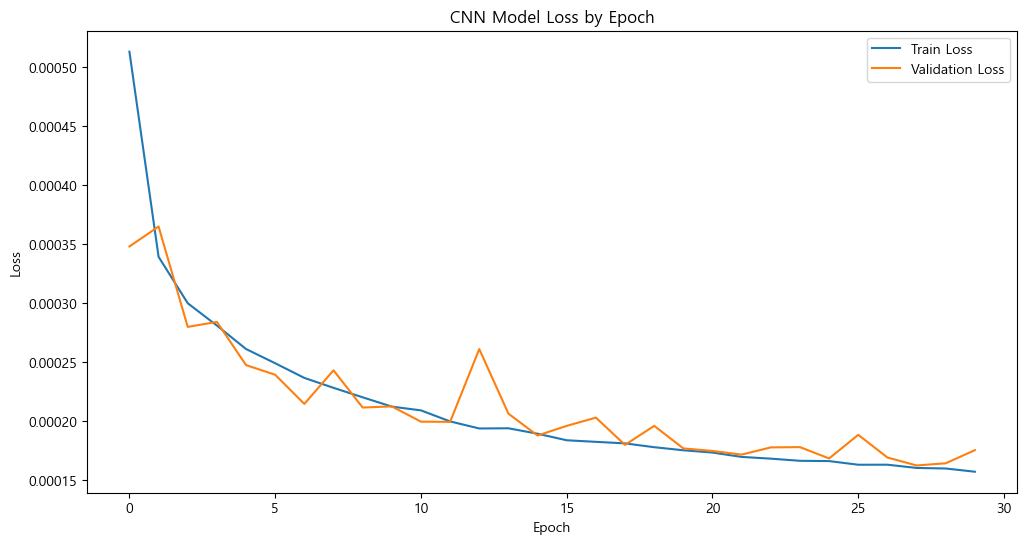

In [50]:
from tensorflow.keras.models import Sequential  # 케라스 시퀀셜 모델(순차적 모델) 임포트
from tensorflow.keras.layers import Conv1D, Flatten, Dense  # 1D 합성곱, 평탄화, 완전연결층 임포트
from tensorflow.keras.optimizers import Adam  # Adam 옵티마이저 임포트
from sklearn.metrics import mean_squared_error, r2_score  # 평가 지표(MSE, R2) 임포트

# 1. CNN 모델 정의
model = Sequential([
    # 첫 번째 1D 합성곱 레이어: 32개 필터, 커널 크기 2, ReLU 활성화
    # 입력 형태는 (window_size, 2) → window_size=3, 2는 승차/하차 두 특성
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(window_size, 2)),
    # 두 번째 1D 합성곱 레이어: 64개 필터, 커널 크기 2, ReLU 활성화
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    # 3차원 출력을 1차원 벡터로 변환 (Dense 층 입력을 위해)
    Flatten(),
    # 완전연결층: 64개 뉴런, ReLU 활성화
    Dense(64, activation='relu'),
    # 출력층: 2개 뉴런(승차/하차 예측)
    Dense(2)
])

# 2. 모델 컴파일
model.compile(
    optimizer=Adam(0.0005),  # Adam 옵티마이저, 학습률 0.0005
    loss='mse'               # 손실 함수: 평균제곱오차(MSE)
)

# 3. 모델 학습
history_cnn = model.fit(
    X_train, y_train,         # 훈련 입력/타깃
    epochs=30,                # 전체 데이터 30회 반복 학습
    batch_size=32,            # 미니배치 크기 32
    validation_split=0.2,     # 훈련 데이터 중 20%를 검증용으로 사용
    validation_data=(X_test, y_test)  # 추가로 테스트셋을 검증에 사용
)

# 4. 예측 및 평가
y_pred = model.predict(X_test)  # 테스트 데이터 예측
mse = mean_squared_error(y_test, y_pred)  # 평균제곱오차(MSE) 계산
r2 = r2_score(y_test, y_pred)             # 결정계수(R2) 계산
print(f'CNN Test MSE: {mse:.2f}, R2: {r2:.2f}')  # 평가 결과 출력

# 5. 학습 곡선(손실) 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history_cnn.history['loss'], label='Train Loss')         # 에폭별 훈련 손실
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')# 에폭별 검증 손실
plt.title('CNN Model Loss by Epoch')  # 그래프 제목
plt.ylabel('Loss')                    # y축 레이블
plt.xlabel('Epoch')                   # x축 레이블
plt.legend()                          # 범례
plt.show()                            # 그래프 출력



Epoch 1/30


c:\Users\kkh01\llll\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\kkh01\llll\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1625/1625 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0015 - val_loss: 1.4031e-04
Epoch 2/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.3978e-04 - val_loss: 1.3884e-04
Epoch 3/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.8697e-04 - val_loss: 1.4922e-04
Epoch 4/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.4083e-04 - val_loss: 1.4190e-04
Epoch 5/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.1254e-04 - val_loss: 1.4616e-04
Epoch 6/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.7987e-04 - val_loss: 1.5767e-04
Epoch 7/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.4649e-04 - val_loss: 1.3080e-04
Epoch 8/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.1821e-04 - val_loss: 1.2147e-04
Epoch 9/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.9169e-04 - val_loss: 1.0966e-04
Epoch 10/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.7049e-04 - val_loss: 1.3213e-04
Epoch 11/30
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

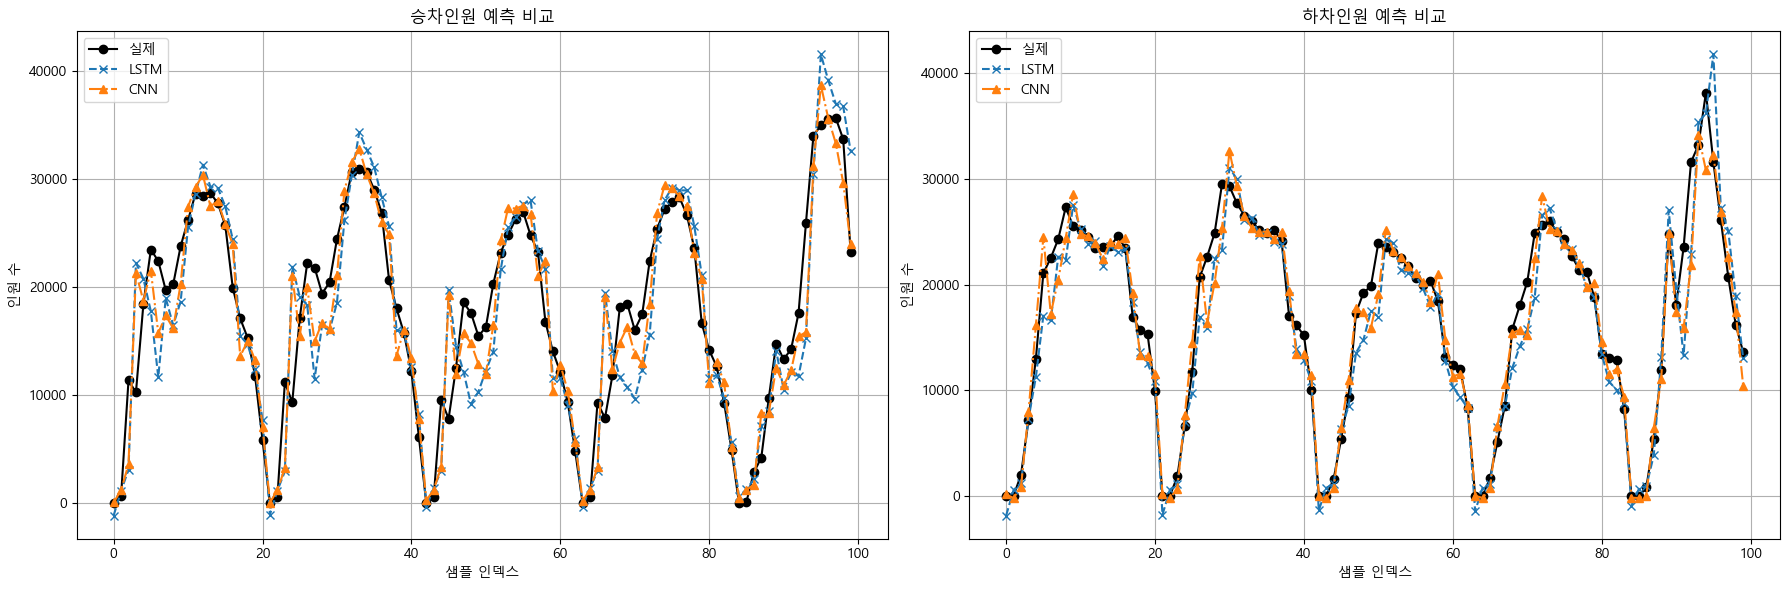

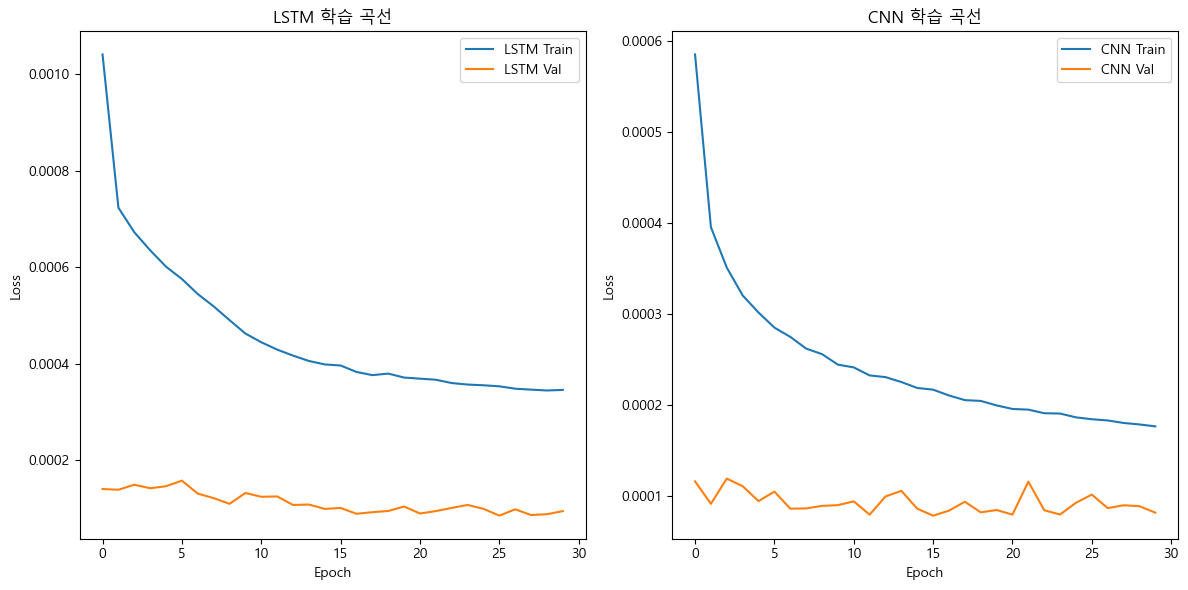

In [51]:
import tensorflow as tf  # 텐서플로우 전체 패키지 임포트

# 1. 데이터 전처리 (여기에 기존 데이터 전처리 코드가 들어가야 함)
# 예시: X_train, y_train, X_test, y_test, scaler_y 등 준비

# 2. 모델 정의
# LSTM 모델 정의: 시계열 패턴 학습에 특화
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),  # 64 유닛 LSTM, 입력 (윈도우 크기, 특성 수)
    Dropout(0.2),                 # 과적합 방지를 위한 드롭아웃(20%)
    Dense(32, activation='relu'),  # 은닉층: 32개 뉴런, ReLU 활성화
    Dense(2)                      # 출력층: 승차/하차 2개 값 예측
])
lstm_model.compile(optimizer='adam', loss='mse')  # Adam 옵티마이저, 평균제곱오차 손실 함수로 컴파일

# CNN 모델 정의: 지역적 패턴 추출에 강점
cnn_model = Sequential([
    Conv1D(32, 2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),  # 1D 합성곱, 32 필터, 커널 크기 2
    Conv1D(64, 2, activation='relu'),  # 두 번째 합성곱, 64 필터
    Flatten(),                         # 3D 출력을 1D 벡터로 변환
    Dense(64, activation='relu'),      # 완전연결층: 64개 뉴런, ReLU 활성화
    Dense(2)                           # 출력층: 승차/하차 2개 값 예측
])
cnn_model.compile(optimizer=Adam(0.0005), loss='mse')  # Adam(학습률 0.0005), 평균제곱오차 손실 함수

# 3. 모델 학습
# LSTM 모델 학습
lstm_history = lstm_model.fit(
    X_train, y_train,         # 훈련 입력/타깃 데이터
    epochs=30,                # 30 에폭 반복
    batch_size=128,           # 배치 크기 128
    validation_split=0.2,     # 훈련 데이터의 20%를 검증 데이터로 사용
    verbose=1                 # 학습 진행상황 출력
)

# CNN 모델 학습
cnn_history = cnn_model.fit(
    X_train, y_train,         # 훈련 입력/타깃 데이터
    epochs=30,                # 30 에폭 반복
    batch_size=32,            # 배치 크기 32
    validation_split=0.2,     # 훈련 데이터의 20%를 검증 데이터로 사용
    verbose=1                 # 학습 진행상황 출력
)

# 4. 예측 및 역정규화 (정규화된 예측/실제값을 원래 단위로 복원)
# LSTM 예측 및 역정규화
lstm_pred = lstm_model.predict(X_test)  # 테스트 입력 데이터로 예측
lstm_pred_inv = scaler_y.inverse_transform(lstm_pred)  # 예측값 역정규화

# CNN 예측 및 역정규화
cnn_pred = cnn_model.predict(X_test)    # 테스트 입력 데이터로 예측
cnn_pred_inv = scaler_y.inverse_transform(cnn_pred)    # 예측값 역정규화

# 실제값 역정규화
y_test_inv = scaler_y.inverse_transform(y_test)         # 테스트 실제값 역정규화

# 5. 실제 vs 예측 통합 시각화 함수 정의
def plot_comparison(num_samples=100):
    """
    LSTM, CNN, 실제값의 승차/하차 예측 결과를 한 번에 비교 시각화
    num_samples: 시각화할 샘플 개수
    """
    plt.figure(figsize=(18, 6))
    
    # 승차인원 비교
    plt.subplot(1, 2, 1)
    plt.plot(y_test_inv[:num_samples, 0], label='실제', marker='o', color='black')      # 실제 승차인원(검정색 원)
    plt.plot(lstm_pred_inv[:num_samples, 0], label='LSTM', marker='x', linestyle='--') # LSTM 예측(파란색 x, 점선)
    plt.plot(cnn_pred_inv[:num_samples, 0], label='CNN', marker='^', linestyle='-.')   # CNN 예측(주황색 ^, 점선)
    plt.title('승차인원 예측 비교')
    plt.xlabel('샘플 인덱스')
    plt.ylabel('인원 수')
    plt.legend()
    plt.grid(True)

    # 하차인원 비교
    plt.subplot(1, 2, 2)
    plt.plot(y_test_inv[:num_samples, 1], label='실제', marker='o', color='black')      # 실제 하차인원(검정색 원)
    plt.plot(lstm_pred_inv[:num_samples, 1], label='LSTM', marker='x', linestyle='--') # LSTM 예측(파란색 x, 점선)
    plt.plot(cnn_pred_inv[:num_samples, 1], label='CNN', marker='^', linestyle='-.')   # CNN 예측(주황색 ^, 점선)
    plt.title('하차인원 예측 비교')
    plt.xlabel('샘플 인덱스')
    plt.ylabel('인원 수')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 6. 학습 과정(손실 변화) 시각화 함수 정의
def plot_training_history():
    """
    LSTM, CNN 학습/검증 손실 곡선을 한 번에 시각화
    """
    plt.figure(figsize=(12, 6))
    
    # LSTM 손실 곡선
    plt.subplot(1, 2, 1)
    plt.plot(lstm_history.history['loss'], label='LSTM Train')      # LSTM 훈련 손실
    plt.plot(lstm_history.history['val_loss'], label='LSTM Val')    # LSTM 검증 손실
    plt.title('LSTM 학습 곡선')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    # CNN 손실 곡선
    plt.subplot(1, 2, 2)
    plt.plot(cnn_history.history['loss'], label='CNN Train')        # CNN 훈련 손실
    plt.plot(cnn_history.history['val_loss'], label='CNN Val')      # CNN 검증 손실
    plt.title('CNN 학습 곡선')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 7. 시각화 함수 실행 (실제 vs 예측, 학습 곡선)
plot_comparison()
plot_training_history()



   1/1630 ━━━━━━━━━━━━━━━━━━━━ 2:11 81ms/step

c:\Users\kkh01\llll\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\kkh01\llll\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1630/1630 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step
Metric         CNN            LSTM           
MSE            0.0050     0.0050
R-squared      -0.3774     -0.4143


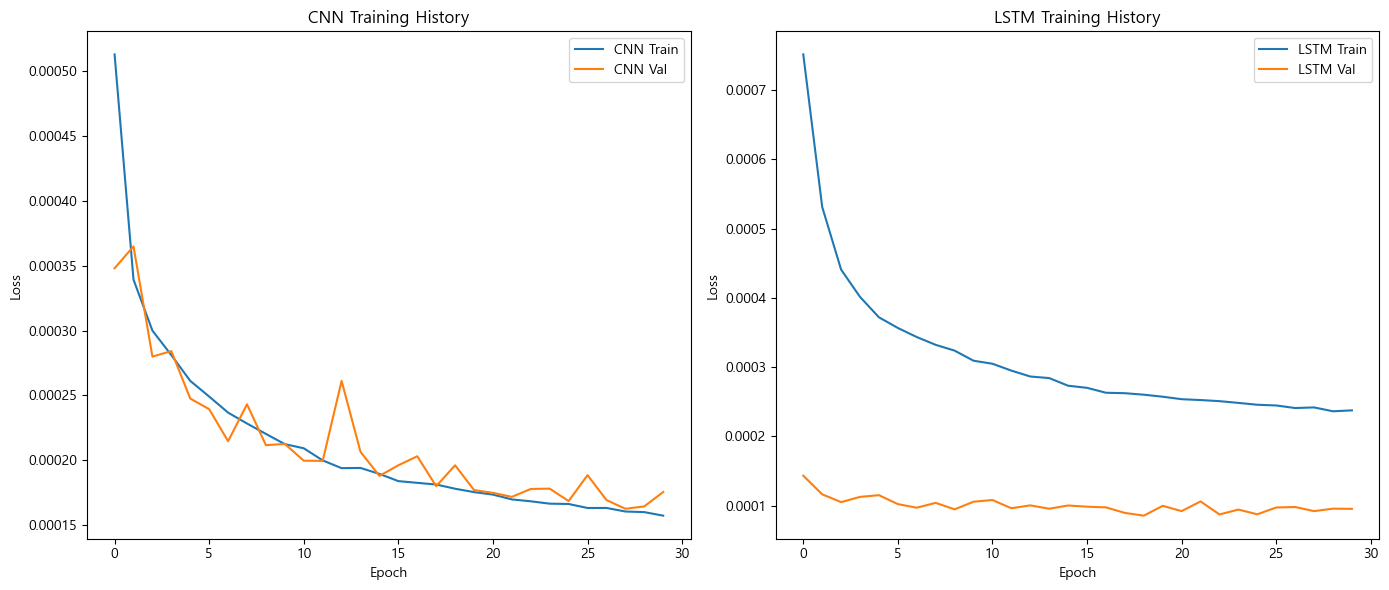

In [53]:
# LSTM 모델 정의
lstm_model = Sequential([
    # LSTM 레이어: 64개 유닛, 입력 형태 (윈도우 크기, 특성 수)
    # - input_shape: (시간 스텝 수, 특성 수) → (3, 2) 형태의 3D 텐서 입력
    # - return_sequences=False: 마지막 시간 스텝의 출력만 사용
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    
    # 드롭아웃 레이어: 과적합 방지를 위해 20% 뉴런 비활성화
    # - 0.2: 무작위로 20%의 뉴런 연결을 끊어 일반화 성능 향상
    Dropout(0.2),
    
    # 완전연결층: 32개 뉴런, ReLU 활성화 함수
    # - 비선형 변환을 통해 복잡한 패턴 학습
    Dense(32, activation='relu'),
    
    # 출력층: 2개 뉴런 (승차/하차 동시 예측)
    # - 활성화 함수 없음: 회귀 문제이므로 그대로 출력
    Dense(2)
])

# CNN 모델 정의
cnn_model = Sequential([
    # 1D 합성곱 레이어: 32개 필터, 커널 크기 2
    # - 시간 축 방향으로 지역 패턴 추출
    # - input_shape: (윈도우 크기, 특성 수) → (3, 2) 형태 입력
    Conv1D(32, 2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    
    # 두 번째 1D 합성곱 레이어: 64개 필터
    # - 저수준 패턴을 조합해 고수준 특징 추출
    Conv1D(64, 2, activation='relu'),
    
    # 평탄화 레이어: 3D → 1D 변환
    # - 합성곱 결과를 Dense 층 입력에 맞게 변형
    Flatten(),
    
    # 완전연결층: 64개 뉴런, ReLU 활성화
    # - 합성곱 결과를 종합하여 예측에 필요한 특징 학습
    Dense(64, activation='relu'),
    
    # 출력층: 2개 뉴런 (승차/하차 동시 예측)
    Dense(2)
])

# LSTM 예측값 생성
y_pred_lstm = lstm_model.predict(X_test)
# - X_test: (샘플 수, 3, 2) 형태의 테스트 데이터
# - 출력: (샘플 수, 2) 형태 예측값 (승차/하차)

# CNN 예측값 생성 
y_pred_cnn = cnn_model.predict(X_test)
# - X_test: (샘플 수, 3, 2) 형태 테스트 데이터
# - 출력: (샘플 수, 2) 형태 예측값

# 모델 비교 함수 호출
compare_models(
    y_test,          # 실제값 (정규화된 상태)
    y_pred_cnn,      # CNN 예측값
    y_pred_lstm,     # LSTM 예측값
    history_cnn,     # CNN 학습 기록 (loss, val_loss 저장)
    history_lstm     # LSTM 학습 기록
)
